# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [142]:
import pandas as pd
import numpy as np
import math
import json

# Ensure inline plotting with matplotlib in Jupyter Notebook
%matplotlib inline  

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import LabelEncoder, StandardScaler  # Combined imports
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Set the option to display all columns in pandas DataFrame
pd.set_option('display.max_columns', None)

# Load the JSON files for portfolio, profile, and transcript datasets
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Portfolio

In [143]:
portfolio_modified = portfolio.copy()

# Extract all unique channels from the 'channels' column by flattening the lists and converting them into a set
unique_strings = set(sum(portfolio_modified['channels'], []))

# For each unique channel (string), create a new column in the DataFrame with one-hot encoding
for string in unique_strings:
    portfolio_modified[string] = portfolio_modified['channels'].apply(lambda x: 1 if string in x else 0)

# Convert the 'duration' column (assumed to be in days) to hours by multiplying it by 24
portfolio_modified['duration_h'] = portfolio_modified['duration'] * 24

# Define the desired order of columns for the final DataFrame
new_column_order = ['id', 'offer_type', 'difficulty', 'duration_h', 'reward', 'social', 'email', 'web', 'mobile']
portfolio_modified = portfolio_modified.reindex(columns=new_column_order)

portfolio_modified = portfolio_modified.sort_values(['offer_type', 'difficulty', 'duration_h'])

portfolio_modified

,id,offer_type,difficulty,duration_h,reward,social,email,web,mobile
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,120,5,1,1,1,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,168,5,0,1,1,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,120,10,1,1,1,1
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,168,10,1,1,0,1
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,168,3,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,discount,10,168,2,0,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,240,2,1,1,1,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,240,5,0,1,1,0
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,72,0,1,1,0,1
2,3f207df678b143eea3cee63160fa8bed,informational,0,96,0,0,1,1,1


There are 4 BOGO offer types, 4 DISCOUNT offer types, and 2 INFORMATIONAL offer types. The channels are separated into columns. Duration is multiplied by 24 to convert it into hours. The "difficulty" column shows how much must be spent to qualify for the offer. For example, a customer should pay \\$5 for a coffee to get another \\$5 coffee for free. The "Reward" of an offer is also recorded. For BOGO offers, the reward is equal to the difficulty, while for DISCOUNT offers, the reward is the amount of the discount, which can be 2, 3, or 5 dollars depending on the difficulty level.

# Profile

In [144]:
print(profile.shape)  
profile.head()        

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [145]:
print(profile[profile.duplicated(keep=False)].shape)  # Print the shape of duplicated rows in the 'profile' DataFrame
print(profile['id'].unique().shape)  
print(profile['income'].describe())

(0, 5)
(17000,)
count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64


The profile dataset provides information about the customers, including gender, age, the date the person became a member, and the person's income. Each person is identified by an ID. There are no duplicate values, and the dataset contains 17,000 unique individuals.

   Count  Percentage
M   8484   49.905882
F   6129   36.052941
O    212    1.247059


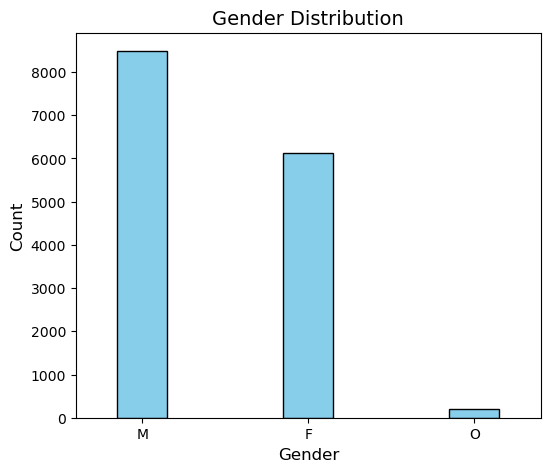

In [146]:
# Calculate gender counts and total count
gender_counts = profile['gender'].value_counts() 
total_count = profile.shape[0] 

# Calculate the percentage for each gender
gender_percentages = (gender_counts / total_count) * 100  

# Combine counts and percentages into a DataFrame
gender_summary = pd.DataFrame({
    'Count': gender_counts,        # Add gender counts
    'Percentage': gender_percentages  # Add percentage calculations
})

print(gender_summary)  

plt.figure(figsize=(6, 5))  # Adjust the size of the figure for better label display
gender_counts.plot(kind='bar', color='skyblue', edgecolor='black', width=0.3) 

# Add labels and title
plt.title('Gender Distribution', fontsize=14)  # Title of the plot
plt.xlabel('Gender', fontsize=12)  # Label for the x-axis
plt.ylabel('Count', fontsize=12)   # Label for the y-axis

# Keep labels horizontal and adjust font size
plt.xticks(rotation=0, fontsize=10)  

plt.show() 

In [147]:
profile['gender'].isna().sum()  # Count the number of missing (NaN) values in the 'gender' column

2175

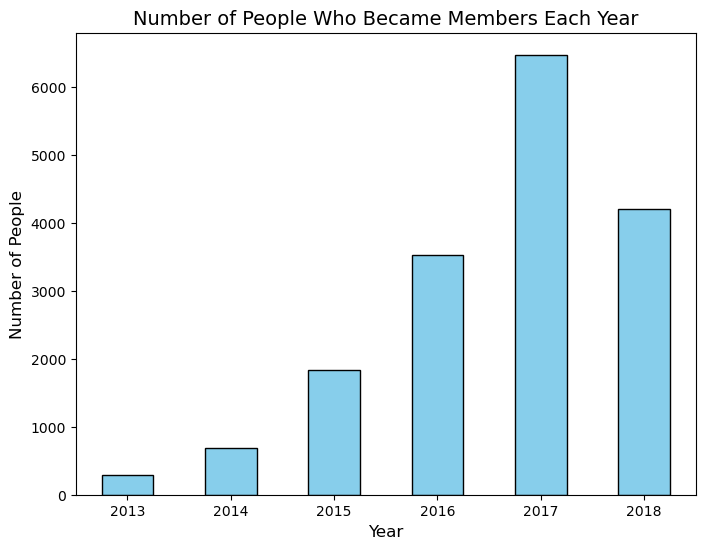

In [148]:
# Convert the 'became_member_on' column to datetime format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# Extract the year and store it in a new 'year' column
profile['year'] = profile['became_member_on'].dt.year

# Count the number of people who became members in each year
yearly_counts = profile['year'].value_counts().sort_index()

# Create a bar plot of the number of people in each year
plt.figure(figsize=(8, 6))
yearly_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Number of People Who Became Members Each Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of People', fontsize=12)

# Adjust the font size for x-axis labels
plt.xticks(rotation=0, fontsize=10)

plt.show()

# Transcript

In [149]:
print(transcript.shape)
transcript.head(10)

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [150]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

The Transcript dataset contains, for each person, the events at each time. Events include "transaction", "offer received", "offer viewed", and "offer completed". 
<br> The Transcript dataset also includes the "Value" column, which contains dictionaries that include the "offer ID" and, when an offer is completed, the amount of the "reward". The following lines store these values in separate columns.

In [151]:
# Sort the transcript DataFrame by 'person' and 'time' to organize events chronologically per person
transcript_sorted = transcript.sort_values(['person', 'time'])

# Expand the 'value' column (which contains dictionaries) into separate columns in a new DataFrame
transcript_value_expanded = pd.DataFrame(transcript_sorted['value'].apply(lambda x: pd.Series(x)))

# Condition to handle cases where 'offer_id' is populated but 'offer id' is not
condition = (transcript_value_expanded['offer id'].isnull() & transcript_value_expanded.offer_id.notnull())

# Fill missing 'offer id' values using the 'offer_id' column where applicable
transcript_value_expanded.loc[condition, 'offer id'] = transcript_value_expanded.loc[condition, 'offer_id']

# Drop the redundant 'offer_id' column
transcript_value_expanded = transcript_value_expanded.drop('offer_id', axis=1)

# Creating the DataFrame for Analysis
Starting with the Transcript dataset and later merging other datasets, the `df` DataFrame will be used for analysis.

In [152]:
# Merge the sorted transcript DataFrame with the expanded 'value' columns
df = pd.merge(transcript_sorted, transcript_value_expanded, left_index=True, right_index=True)

# Rename the 'offer id' column to 'id' for consistency
df = df.rename(columns={'offer id': 'id'})

In [153]:
# Drop duplicate rows, keeping the first occurrence
df.drop_duplicates(subset=['person', 'id', 'event', 'time'], keep='first', inplace=True)

# Reset the index after dropping duplicates and drop the old index
df.reset_index(drop=True, inplace=True)

In [154]:
print(df.shape)
print(df['event'].value_counts())
df.head(3)

(306137, 7)
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33182
Name: event, dtype: int64


,person,event,value,time,id,amount,reward
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,NaN,22.16,NaN


### Amount
The following code lines calculate the accumulated transaction amount for each person chronologically.

In [155]:
amount = df.sort_values(['person', 'time'])[['person', 'time', 'amount']]

# Calculate the cumulative transaction amount for each person
amount['amount_cum'] = amount.groupby(['person'])['amount'].cumsum()

# Drop rows where 'amount' is missing (NaN)
amount = amount.dropna(subset=['amount'])

# Assign a sequential transaction number for each person
amount['transaction_number'] = amount.groupby(['person'])['amount'].cumcount() + 1

# Add a column that records the total number of transactions per person
amount['transaction_count'] = amount.groupby(['person'])['transaction_number'].transform('max')

In [156]:
print(amount[amount.duplicated(keep=False)].shape) # Print the shape of the DataFrame containing duplicated rows (if any)
amount.head(3)

(0, 6)


,person,time,amount,amount_cum,transaction_number,transaction_count
2,0009655768c64bdeb2e877511632db8f,228,22.16,22.16,1,8
6,0009655768c64bdeb2e877511632db8f,414,8.57,30.73,2,8
10,0009655768c64bdeb2e877511632db8f,528,14.11,44.84,3,8


In [157]:
# Group by 'person' and get unique cumulative amounts for each person
amount_cum_unique = amount.groupby('person')['amount_cum'].unique()

# Flatten the list of unique cumulative amounts into a single series
all_unique_values = pd.Series([value for sublist in amount_cum_unique for value in sublist])

all_unique_values.describe()

count    138953.000000
mean         71.948588
std          97.783290
min           0.050000
25%          15.460000
50%          40.360000
75%          97.250000
max        1608.690000
dtype: float64

### Event
The following lines aggregate the chronologically ordered events for each person-offer combination. Then, from the resulting aggregated columns, new columns are generated to show whether a received offer was viewed or not, and whether it was completed or not.

In [158]:
# Sort the DataFrame by 'person', 'id', and 'time' to organize events chronologically per person-offer combination
event = df.sort_values(['person', 'id', 'time'])

# Select only the relevant columns
event = event[['person', 'id', 'time', 'event']]

# Reorder the columns
event = event.reindex(columns=['person', 'id', 'time', 'event'])

In [159]:
values_to_drop = ['transaction']

# Filter out the 'transaction' events, keeping only relevant offer-related events
event = event[~event['event'].isin(values_to_drop)]

Transaction events are dropped because these events do not have an "offer id" and cannot be matched with any offer.

#### Aggregating events for each person

In [160]:
# Group by 'person' and 'id', then aggregate the 'event' and 'time' columns into lists for each group
event = event.groupby(['person', 'id']).agg({
    'event': lambda x: list(x),  # Collect events into a list
    'time': lambda x: list(x)    # Collect time values into a list
}).reset_index()  # Reset the index to turn the grouped columns back into regular columns

In [161]:
event = event.rename(columns={'event': 'events'})
event = event.rename(columns={'time': 'times'})

#### Separating aggregated events for each person-offer combination

In [162]:
# Function to find the indices of 'offer received' events in a list
def find_split_indices(input_list):
    indices = []
    for i in range(len(input_list)):
        if input_list[i] == 'offer received':  # Check if the event is 'offer received'
            indices.append(i)  # Store the index of the 'offer received' event
    return indices

# Function to split a list into sublists based on the provided indices
def split_based_on_indices(input_list, indices):
    result = []
    for i in range(len(indices)):
        start_index = indices[i]  # Start of the sublist
        end_index = indices[i + 1] if i + 1 < len(indices) else len(input_list)  # End of the sublist or end of the list
        result.append(input_list[start_index:end_index])  # Append the sublist to the result
    return result

In [163]:
# Apply the functions to each row of the two columns
event['event-s'] = event.apply(lambda row: split_based_on_indices(row['events'], find_split_indices(row['events'])), axis=1)
event['time-s'] = event.apply(lambda row: split_based_on_indices(row['times'], find_split_indices(row['events'])), axis=1)

#### Expanding the DataFrame to have each row represent a unique combination of persons and offers

In [164]:
# Count the number of 'offer received' events in each 'events' list
event['count_offer_received'] = event['events'].apply(lambda x: x.count('offer received'))

# Create copies of rows based on the 'count_offer_received' column
# For each row, repeat the row as many times as 'offer received' appears in the 'events' list
event_expanded = pd.concat([event.loc[[i]] for i in event.index for _ in range(event.loc[i, 'count_offer_received'])])

# Reset the index of the expanded DataFrame after concatenation
event_expanded.reset_index(drop=True, inplace=True)

# Assign a sequential copy number to each person-offer combination
event_expanded['copy_number'] = event_expanded.groupby(['person', 'id']).cumcount() + 1

In [165]:
# Function to get the jth list from a nested list with column name as input
def extract_jth_list(row, col_name):
    # Unpack the row to get both the list from the specified column and the index
    nested_list, j = row[col_name], row['copy_number']
    
    # Check if j is a valid index, and return the jth list
    if 0 <= j-1 < len(nested_list):
        return nested_list[j-1]  # Return the jth list (adjusting for 1-based index)
    return None  # Return None if the index is out of bounds

In [166]:
# Apply the function to each row in the DataFrame
event_expanded['event'] = event_expanded.apply(extract_jth_list, col_name='event-s', axis=1)
event_expanded['time'] = event_expanded.apply(extract_jth_list, col_name='time-s', axis=1)

In [167]:
event_expanded[['copy_number','event-s', 'event', 'time-s', 'time']].head(3)

,copy_number,event-s,event,time-s,time
0,1,"[[offer received, offer completed]]","[offer received, offer completed]","[[576, 576]]","[576, 576]"
1,1,"[[offer received, offer viewed]]","[offer received, offer viewed]","[[336, 372]]","[336, 372]"
2,1,"[[offer received, offer viewed]]","[offer received, offer viewed]","[[168, 192]]","[168, 192]"


In [168]:
# Drop unnecessary or redundant columns from the expanded event DataFrame
event_final = event_expanded.drop(['events', 'times', 'event-s', 'time-s'], axis=1)

# Create a new column 'offer_completed' to indicate if the event list contains 'offer completed'
event_final['offer_completed'] = event_final['event'].apply(lambda x: 1 if 'offer completed' in x else 0)

# Create a column to count how many times 'offer completed' appears in the event list
event_final['count_offer_comp'] = event_final['event'].apply(lambda x: x.count('offer completed'))

#### There are 81 observations where a received offer is completed more than once.
Because the number of these observations is small compared to the total number of observations, they can be dropped. However, the first completion time is considered, and the data are kept.

In [169]:
# Get the indices of rows where the 'count_offer_comp' is greater than 1 (i.e., offer completed more than once)
filter_81_discount = event_final.index[event_final['count_offer_comp'] > 1].to_list()

event_final.iloc[filter_81_discount].head(3)

,person,id,count_offer_received,copy_number,event,time,offer_completed,count_offer_comp
656,0246e7cc7a3d4a98a940cb13776b5b55,fafdcd668e3743c1bb461111dcafc2a4,2,2,"[offer received, offer completed, offer viewed...","[576, 582, 606, 624]",1,2
1186,041fd7c6b796430a867c4e03d2ff8f4d,0b1e1539f2cc45b7b9fa7c272da2e1d7,3,3,"[offer received, offer completed, offer comple...","[576, 648, 702]",1,2
1739,05e6bcb70fe14e0da4730527ca35a4ae,0b1e1539f2cc45b7b9fa7c272da2e1d7,2,2,"[offer received, offer completed, offer comple...","[504, 510, 540]",1,2


#### Calculation of the time between viewing an offer and receiving it, and the time between completing an offer and receiving it

In [170]:
# Function to find the first occurrence of an event and return its index or NaN if not found
def find_indices(input_list, event):
    for i in range(len(input_list)):
        if input_list[i] == event:
            return i  # Return the first occurrence as an integer
    return np.nan  # Return NaN if the event is not found

# Function to return the value at the given index or NaN if the index is not valid
def time_based_on_indices(input_list, index):
    if not np.isnan(index) and 0 <= index < len(input_list):
        return input_list[index]  # Return the value at the valid index
    return np.nan  # Return NaN if the index is out of bounds or not valid

In [171]:
# Extract the time when the offer was received by applying a function that finds the relevant indices
event_final['time_offer_received'] = event_final.apply(lambda row: 
    time_based_on_indices(row['time'], find_indices(row['event'], 'offer received')), axis=1)

# Extract the time when the offer was viewed by applying a function that finds the relevant indices
event_final['time_offer_viewd'] = event_final.apply(lambda row: 
    time_based_on_indices(row['time'], find_indices(row['event'], 'offer viewed')), axis=1)

# Extract the time when the offer was completed by applying a function that finds the relevant indices
event_final['time_offer_completed'] = event_final.apply(lambda row: 
    time_based_on_indices(row['time'], find_indices(row['event'], 'offer completed')), axis=1)

In [172]:
# Calculate the time difference between viewing the offer and receiving it
event_final['viewed_received'] = event_final['time_offer_viewd'] - event_final['time_offer_received']

# Calculate the time difference between viewing the offer and completing it
event_final['viewed_completed'] = event_final['time_offer_viewd'] - event_final['time_offer_completed']

In [173]:
# Create a binary column indicating if the offer was viewed before or at the same time as it was completed
event_final['offer_viewed_completed'] = (event_final['viewed_completed'] <= 0).astype(int)

# Create a binary column indicating if the offer was viewed between receiving and completing the offer
# or if it was viewed but not completed (NaN in viewed_completed but valid viewed_received)
event_final['offer_viewed'] = (
    ((event_final['viewed_received'] >= 0) & (event_final['viewed_completed'] <= 0)) |  # Offer viewed before completing
    (pd.isna(event_final['viewed_completed']) & pd.notna(event_final['viewed_received']))  # Offer viewed but not completed
).astype(int)

#### Three main outcome variables are created. These dummy variables indicate whether an offer is viewed, completed, or both viewed and completed.

In [174]:
event_final[['event', 'time', 'offer_completed', 'offer_viewed_completed', 'offer_viewed']].tail(3)

,event,time,offer_completed,offer_viewed_completed,offer_viewed
76274,"[offer received, offer completed, offer viewed]","[576, 576, 582]",1,0,0
76275,"[offer received, offer completed, offer viewed]","[504, 504, 534]",1,0,0
76276,"[offer received, offer viewed, offer completed]","[0, 6, 60]",1,1,1


In [175]:
event_final = event_final.rename(columns={'time': 'times', 'event' : 'events'})

event_final.drop(['count_offer_received', 'copy_number', 'count_offer_comp'], axis = 1, inplace = True)

order = ['person', 'id', 'events', 'times', 'offer_viewed', 'offer_completed', 'offer_viewed_completed',
       'time_offer_received', 'time_offer_viewd', 'time_offer_completed',
       'viewed_received', 'viewed_completed']
event_final = event_final[order]

#### Checking the 81 offers that are completed more than once, all of them are discount offers.

In [176]:
# Display specific columns where offers were completed more than once (filtered by 'filter_81_discount')
event_final[['events', 'times', 'time_offer_received', 'time_offer_viewd', 'time_offer_completed', 
             'viewed_received', 'viewed_completed']].iloc[filter_81_discount].head(3)

,events,times,time_offer_received,time_offer_viewd,time_offer_completed,viewed_received,viewed_completed
656,"[offer received, offer completed, offer viewed...","[576, 582, 606, 624]",576,606.0,582.0,30.0,24.0
1186,"[offer received, offer completed, offer comple...","[576, 648, 702]",576,NaN,648.0,NaN,NaN
1739,"[offer received, offer completed, offer comple...","[504, 510, 540]",504,NaN,510.0,NaN,NaN


### Merging

The starting DataFrame is `event_final`, which provides information for each person and offer, including whether the offer was received, viewed, or completed, along with the respective times for each event.

### Merging with Amount

The `event_final` DataFrame will be merged with the `amount` DataFrame to incorporate transaction information for each person and offer combination.

In [177]:
# Perform a left join of 'event_final' and 'amount' on the 'person' column
merged = pd.merge(event_final, amount, on='person', how='left')

# Filter rows where the transaction 'time' occurred before the 'time_offer_received'
filtered = merged[merged['time'] < merged['time_offer_received']]

# Sort by 'person', 'id', 'time_offer_received', and 'time' to get the latest transaction before the offer
filtered = filtered.sort_values(by=['person', 'id', 'time'], ascending=[True, True, False])

# Drop duplicates, keeping only the latest (first) observation for each 'person' and 'time_offer_received'
filtered = filtered.drop_duplicates(subset=['person', 'time_offer_received'], keep='first')

# Merge the filtered DataFrame back with 'event_final' to preserve all rows in 'event_final'
final_result = pd.merge(
    event_final, 
    filtered[['person', 'id', 'time_offer_received', 'time', 'amount', 'amount_cum', 'transaction_number', 'transaction_count']], 
    on=['person', 'id', 'time_offer_received'], how='left')

In [178]:
# Fill missing values in 'amount_cum' with 0
final_result['amount_cum'].fillna(0, inplace=True)

# Fill missing 'transaction_count' by forward filling within each 'person' group, then backward filling if necessary
final_result['transaction_count'] = final_result.groupby('person')['transaction_count'].apply(
    lambda group: group.fillna(method='ffill').fillna(method='bfill'))

# Sort the DataFrame by 'person' and 'time_offer_received'
final_result = final_result.sort_values(['person', 'time_offer_received'])

# Calculate the change in cumulative amount ('amount_cum') for each person and store it in 'amount_cum_chg'
final_result['amount_cum_chg'] = final_result.groupby('person')['amount_cum'].diff()

### Merging with Profile

In [179]:
# Merge 'final_result' with 'portfolio_modified' on 'id' to bring in offer details
final_result = final_result.merge(portfolio_modified, on='id', how='left')

# Rename 'id' in the 'profile' DataFrame to 'person' for consistency before merging
profile.rename(columns={'id': 'person'}, inplace=True)

# Merge 'final_result' with 'profile' on 'person' to bring in customer profile details
final_result = final_result.merge(profile, on='person', how='left')

final_result.head(3)

,person,id,events,times,offer_viewed,offer_completed,offer_viewed_completed,time_offer_received,time_offer_viewd,time_offer_completed,viewed_received,viewed_completed,time,amount,amount_cum,transaction_number,transaction_count,amount_cum_chg,offer_type,difficulty,duration_h,reward,social,email,web,mobile,gender,age,became_member_on,income,year
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,"[offer received, offer viewed]","[168, 192]",1,0,0,168,192.0,NaN,24.0,NaN,NaN,NaN,0.00,NaN,8.0,NaN,informational,0,72,0,1,1,0,1,M,33,2017-04-21,72000.0,2017
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]","[336, 372]",1,0,0,336,372.0,NaN,36.0,NaN,228.0,22.16,22.16,1.0,8.0,22.16,informational,0,96,0,0,1,1,1,M,33,2017-04-21,72000.0,2017
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,"[offer received, offer completed, offer viewed]","[408, 414, 456]",0,1,0,408,456.0,414.0,48.0,42.0,228.0,22.16,22.16,1.0,8.0,0.00,bogo,5,120,5,1,1,1,1,M,33,2017-04-21,72000.0,2017


# Analysis

#### Creating New Variables for Analysis
Quartile dummies for accumulated transaction amounts and income, as well as dummies for gender and offer type, are created.

In [180]:
# Drop the 'email' column from the DataFrame
df = final_result.drop('email', axis=1)

# Create quartile dummies for 'amount_cum'
unique_values = df['amount_cum'].drop_duplicates()  # Remove duplicates to calculate quartiles
unique_quartiles = pd.qcut(unique_values, q=4, labels=False)  # Apply pd.qcut() to assign quartiles
mapping = dict(zip(unique_values, unique_quartiles))  # Map unique values to their respective quartiles
df['amount_cum_quartile'] = df['amount_cum'].map(mapping)  # Map quartiles back to original DataFrame

# Create dummy variables for each quartile
df_dummies = pd.get_dummies(df['amount_cum_quartile'], prefix='amount_cum_q')
df_dummies.columns = df_dummies.columns.str.replace(r'\.0$', '', regex=True)  # Clean up column names
df = pd.concat([df, df_dummies], axis=1)  # Concatenate dummy columns to original DataFrame

# Create quartile dummies for 'income'
unique_values = df['income'].drop_duplicates()
unique_quartiles = pd.qcut(unique_values, q=4, labels=False)
mapping = dict(zip(unique_values, unique_quartiles))
df['income_quartile'] = df['income'].map(mapping)

# Create dummy variables for each income quartile
df_dummies = pd.get_dummies(df['income_quartile'], prefix='income_q')
df_dummies.columns = df_dummies.columns.str.replace(r'\.0$', '', regex=True)
df = pd.concat([df, df_dummies], axis=1)

# Create dummy variables for 'offer_type'
df_dummies = pd.get_dummies(df['offer_type'], prefix='offer_type')
df = pd.concat([df, df_dummies], axis=1)

# Create dummy variables for 'gender'
df_dummies = pd.get_dummies(df['gender'], prefix='gender')
df = pd.concat([df, df_dummies], axis=1)

## Visualization

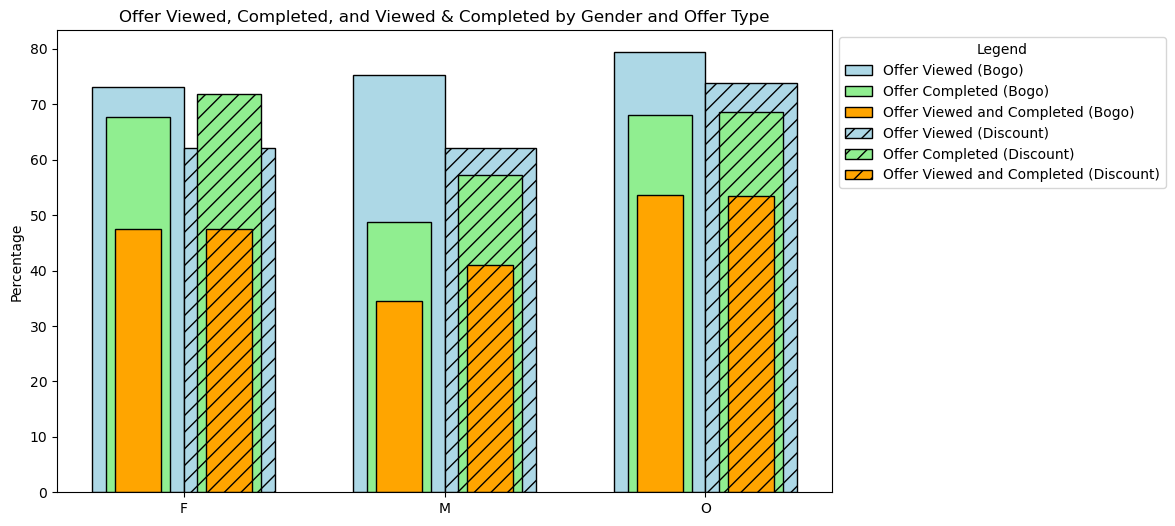

In [181]:
# Filter for "bogo" and "discount" offer types
df_filtered = df[df['offer_type'].isin(['bogo', 'discount'])]

# Calculate percentage of offer_viewed, offer_completed, and offer_viewed_completed per gender and offer_type
offer_viewed_percent = df_filtered.groupby(['gender', 'offer_type'])['offer_viewed'].mean().unstack() * 100
offer_completed_percent = df_filtered.groupby(['gender', 'offer_type'])['offer_completed'].mean().unstack() * 100
offer_viewed_completed_percent = df_filtered.groupby(['gender', 'offer_type'])['offer_viewed_completed'].mean().unstack() * 100

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust width and height as needed

# Define the positions of the bars on the x-axis (grouped by gender and offer_type)
genders = offer_viewed_percent.index
x = np.arange(len(genders))  # Gender positions
bar_width = 0.35  # Width of the bars for each offer_type

# Offset positions for bogo and discount
x_bogo = x - bar_width / 2
x_discount = x + bar_width / 2

# Plot nested bars for each offer_type ("bogo" and "discount")
ax.bar(x_bogo, offer_viewed_percent['bogo'], width=bar_width, label='Offer Viewed (Bogo)', color='lightblue', edgecolor='black')
ax.bar(x_bogo, offer_completed_percent['bogo'], width=bar_width * 0.7, label='Offer Completed (Bogo)', color='lightgreen', edgecolor='black')
ax.bar(x_bogo, offer_viewed_completed_percent['bogo'], width=bar_width * 0.5, label='Offer Viewed and Completed (Bogo)', color='orange', edgecolor='black')

ax.bar(x_discount, offer_viewed_percent['discount'], width=bar_width, label='Offer Viewed (Discount)', color='lightblue', edgecolor='black', hatch='//')
ax.bar(x_discount, offer_completed_percent['discount'], width=bar_width * 0.7, label='Offer Completed (Discount)', color='lightgreen', edgecolor='black', hatch='//')
ax.bar(x_discount, offer_viewed_completed_percent['discount'], width=bar_width * 0.5, label='Offer Viewed and Completed (Discount)', color='orange', edgecolor='black', hatch='//')

# Add labels and title
ax.set_xticks(x)
ax.set_xticklabels(genders)
ax.set_ylabel('Percentage')
ax.set_title('Offer Viewed, Completed, and Viewed & Completed by Gender and Offer Type')

# Move the legend to the top right corner without covering the bars
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Legend')

plt.show()

Only Discount and Bogo offers are considered because the informational offers have no "offer completed" record in the dataset. A higher fraction (and number) of men view the offers. However, a higher fraction of females (compared to males) complete the offers. Generally, a higher fraction of women complete the offers without viewing them.

Middle-aged    6907
Old            5534
Young          2374
Unknown        2179
Name: age_group, dtype: int64
Middle-aged    0.406438
Old            0.325644
Young          0.139696
Unknown        0.128222
Name: age_group, dtype: float64


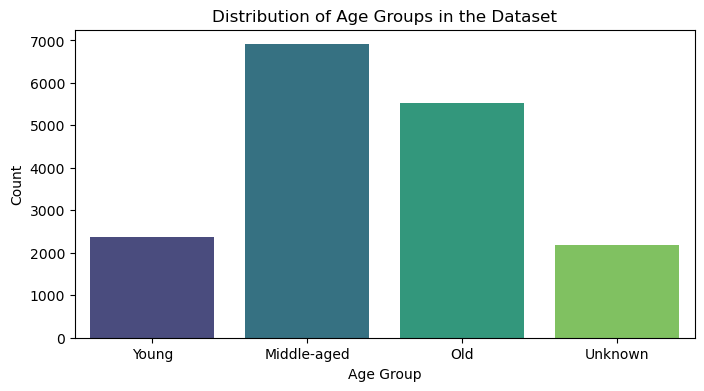

In [182]:
# Clean the data: Remove outliers (ages outside reasonable range) and handle missing values
df['age'] = df['age'].apply(lambda x: None if x is None or x < 18 or x > 100 else x)

# Create age groups (Young: 18-35, Middle-aged: 36-60, Old: 61-100)
def age_group(age):
    if pd.isna(age):
        return 'Unknown'
    elif age <= 35:
        return 'Young'
    elif age <= 60:
        return 'Middle-aged'
    else:
        return 'Old'
    
df['age_group'] = pd.Categorical(df['age'].apply(age_group), categories=['Young', 'Middle-aged', 'Old', 'Unknown'], ordered=True)

# Remove duplicate entries for each person, keeping only one entry per individual
df_unique = df.drop_duplicates(subset='person')

total_count = df_unique.shape[0]
print(df_unique['age_group'].value_counts())
print(df_unique['age_group'].value_counts()/total_count)

# Plot the distribution of age groups
plt.figure(figsize=(8, 4))
sns.countplot(data=df_unique, x='age_group', palette='viridis') 
plt.title('Distribution of Age Groups in the Dataset')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

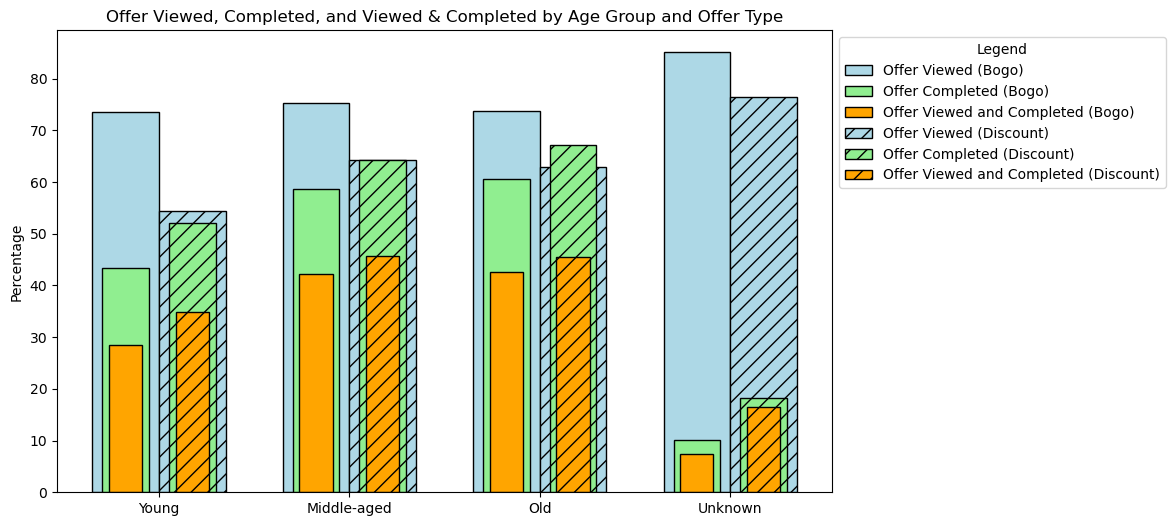

In [183]:
# Create dummy variables for the 'age_group' column, prefixing columns with 'age'
df_dummies = pd.get_dummies(df['age_group'], prefix='age')

# Concatenate the dummy variables back to the original DataFrame
df = pd.concat([df, df_dummies], axis=1)

# Ensure age_group column follows the correct order
df['age_group'] = pd.Categorical(df['age_group'], categories=['Young', 'Middle-aged', 'Old', 'Unknown'], ordered=True)

# Filter for "bogo" and "discount" offer types
df_filtered = df[df['offer_type'].isin(['bogo', 'discount'])]

# Calculate percentage of offer_viewed, offer_completed, and offer_viewed_completed per age_group and offer_type
offer_viewed_percent = df_filtered.groupby(['age_group', 'offer_type'])['offer_viewed'].mean().unstack() * 100
offer_completed_percent = df_filtered.groupby(['age_group', 'offer_type'])['offer_completed'].mean().unstack() * 100
offer_viewed_completed_percent = df_filtered.groupby(['age_group', 'offer_type'])['offer_viewed_completed'].mean().unstack() * 100

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define the positions of the bars on the x-axis (grouped by age_group and offer_type)
age_groups = offer_viewed_percent.index
x = np.arange(len(age_groups))  # Age group positions
bar_width = 0.35  # Width of the bars for each offer_type

# Offset positions for bogo and discount
x_bogo = x - bar_width / 2
x_discount = x + bar_width / 2

# Plot nested bars for each offer_type ("bogo" and "discount")
ax.bar(x_bogo, offer_viewed_percent['bogo'], width=bar_width, label='Offer Viewed (Bogo)', color='lightblue', edgecolor='black')
ax.bar(x_bogo, offer_completed_percent['bogo'], width=bar_width * 0.7, label='Offer Completed (Bogo)', color='lightgreen', edgecolor='black')
ax.bar(x_bogo, offer_viewed_completed_percent['bogo'], width=bar_width * 0.5, label='Offer Viewed and Completed (Bogo)', color='orange', edgecolor='black')

ax.bar(x_discount, offer_viewed_percent['discount'], width=bar_width, label='Offer Viewed (Discount)', color='lightblue', edgecolor='black', hatch='//')
ax.bar(x_discount, offer_completed_percent['discount'], width=bar_width * 0.7, label='Offer Completed (Discount)', color='lightgreen', edgecolor='black', hatch='//')
ax.bar(x_discount, offer_viewed_completed_percent['discount'], width=bar_width * 0.5, label='Offer Viewed and Completed (Discount)', color='orange', edgecolor='black', hatch='//')

# Add labels and title
ax.set_xticks(x)
ax.set_xticklabels(age_groups)
ax.set_ylabel('Percentage')
ax.set_title('Offer Viewed, Completed, and Viewed & Completed by Age Group and Offer Type')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Legend')

plt.show()

Compared to young people, a higher fraction of middle-aged and older individuals complete the offers. This could be because they favor Starbucks coffee more, or it may be due to higher income levels being associated with older age groups.

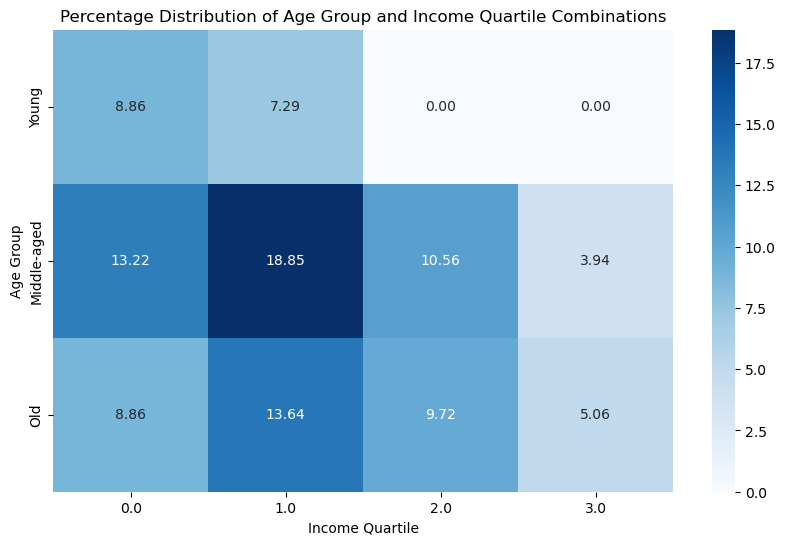

In [184]:
# Cross-tabulation to count the occurrences of each pair combination (age group and income quartile)
# Normalized to get percentages
crosstab = pd.crosstab(df['age_group'][df['age_group'] != 'Unknown'], df['income_quartile'], normalize='all') * 100

# Set up the figure size
plt.figure(figsize=(10, 6))

# Create a heatmap to visualize the percentage distribution of age group and income quartile combinations
sns.heatmap(crosstab, annot=True, cmap='Blues', fmt=".2f")

# Add title and axis labels
plt.title('Percentage Distribution of Age Group and Income Quartile Combinations')
plt.xlabel('Income Quartile')
plt.ylabel('Age Group')

# Save the plot
plt.savefig('age_group_distribution.png', format='png', dpi=300)

plt.show()

There are no young individuals in the 3rd and 4th income quartiles. A higher fraction of middle-aged individuals (compared to older individuals) are in the first and second income quartiles, while almost equal fractions are in the third and fourth income quartiles.

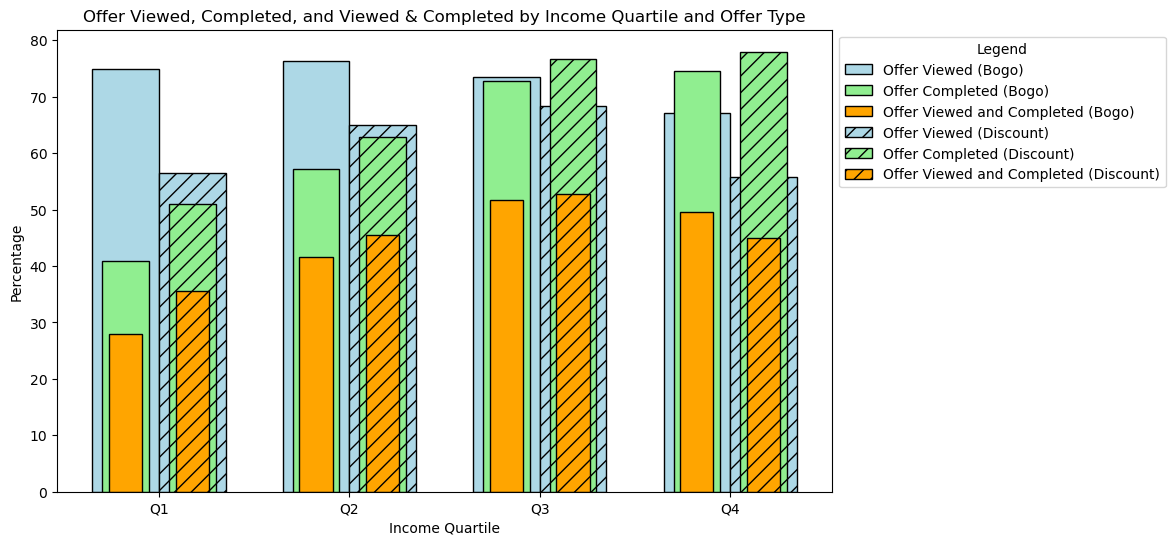

In [185]:
# Ensure income_quartile follows the correct order (0, 1, 2, 3)
df['income_quartile'] = pd.Categorical(df['income_quartile'], categories=[0, 1, 2, 3], ordered=True)

# Filter for "bogo" and "discount" offer types
df_filtered = df[df['offer_type'].isin(['bogo', 'discount'])]

# Calculate percentage of offer_viewed, offer_completed, and offer_viewed_completed per income_quartile and offer_type
offer_viewed_percent = df_filtered.groupby(['income_quartile', 'offer_type'])['offer_viewed'].mean().unstack() * 100
offer_completed_percent = df_filtered.groupby(['income_quartile', 'offer_type'])['offer_completed'].mean().unstack() * 100
offer_viewed_completed_percent = df_filtered.groupby(['income_quartile', 'offer_type'])['offer_viewed_completed'].mean().unstack() * 100

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define the positions of the bars on the x-axis (grouped by income_quartile and offer_type)
income_quartiles = offer_viewed_percent.index
x = np.arange(len(income_quartiles))  # Income quartile positions
bar_width = 0.35  # Width of the bars for each offer_type

# Offset positions for bogo and discount
x_bogo = x - bar_width / 2
x_discount = x + bar_width / 2

# Plot nested bars for each offer_type ("bogo" and "discount")
ax.bar(x_bogo, offer_viewed_percent['bogo'], width=bar_width, label='Offer Viewed (Bogo)', color='lightblue', edgecolor='black')
ax.bar(x_bogo, offer_completed_percent['bogo'], width=bar_width * 0.7, label='Offer Completed (Bogo)', color='lightgreen', edgecolor='black')
ax.bar(x_bogo, offer_viewed_completed_percent['bogo'], width=bar_width * 0.5, label='Offer Viewed and Completed (Bogo)', color='orange', edgecolor='black')

ax.bar(x_discount, offer_viewed_percent['discount'], width=bar_width, label='Offer Viewed (Discount)', color='lightblue', edgecolor='black', hatch='//')
ax.bar(x_discount, offer_completed_percent['discount'], width=bar_width * 0.7, label='Offer Completed (Discount)', color='lightgreen', edgecolor='black', hatch='//')
ax.bar(x_discount, offer_viewed_completed_percent['discount'], width=bar_width * 0.5, label='Offer Viewed and Completed (Discount)', color='orange', edgecolor='black', hatch='//')

# Add labels and title
ax.set_xticks(x)
ax.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])  # Set labels as Q1, Q2, Q3, Q4
ax.set_xlabel('Income Quartile')
ax.set_ylabel('Percentage')
ax.set_title('Offer Viewed, Completed, and Viewed & Completed by Income Quartile and Offer Type')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Legend')

# Save the plot
plt.savefig('Income_Quartile_Offer_Type.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

Breaking down the viewed and completed offers across income groups clearly shows that higher income levels have higher completion rates. In addition, these income groups have a higher fraction of completed offers without viewing the offer.

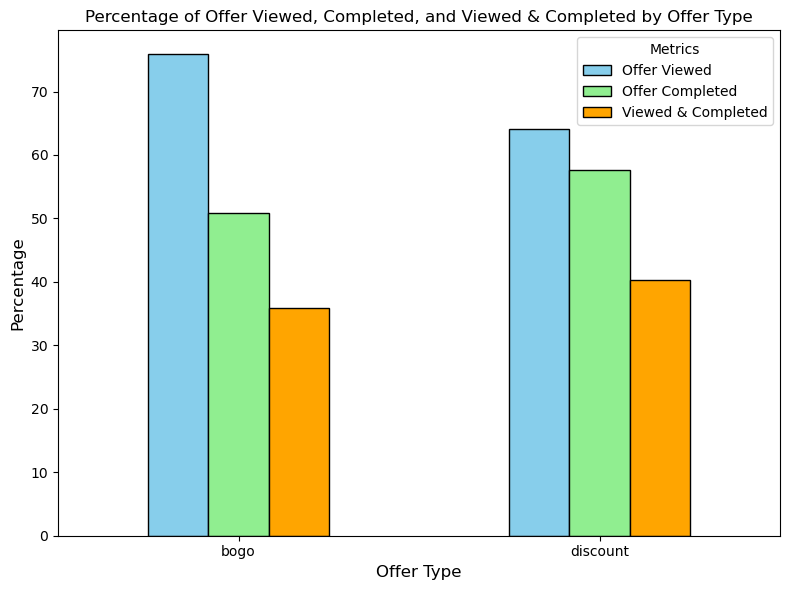

In [186]:
# Filter for "bogo" and "discount" offer types
df_filtered = df[df['offer_type'].isin(['bogo', 'discount'])]

# Calculate percentage of offer_viewed, offer_completed, and offer_viewed_completed per offer type
offer_viewed_percent = df_filtered.groupby(['offer_type'])['offer_viewed'].mean() * 100
offer_completed_percent = df_filtered.groupby(['offer_type'])['offer_completed'].mean() * 100
offer_viewed_completed_percent = df_filtered.groupby(['offer_type'])['offer_viewed_completed'].mean() * 100

# Combine these percentages into a single DataFrame for easier plotting
percentage_df = pd.DataFrame({
    'Offer Viewed': offer_viewed_percent,
    'Offer Completed': offer_completed_percent,
    'Viewed & Completed': offer_viewed_completed_percent
})

# Create the bar plot
percentage_df.plot(kind='bar', figsize=(8, 6), color=['skyblue', 'lightgreen', 'orange'], edgecolor='black')

# Add labels and title
plt.title('Percentage of Offer Viewed, Completed, and Viewed & Completed by Offer Type', fontsize=12)
plt.xlabel('Offer Type', fontsize=12)
plt.ylabel('Percentage', fontsize=12)

# Display the plot with horizontal x-axis labels and a legend
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.tight_layout()

plt.show()

A higher fraction of Discount offers are completed without being viewed.

#### Further Work on the Dataset
Adding dummy variables, interaction terms, and standardizing variables.

In [187]:
# Create separate scalers for 'difficulty' and 'reward' columns
difficulty_scaler = StandardScaler()
reward_scaler = StandardScaler()

# Standardize the 'difficulty' column
df['difficulty_standardized'] = difficulty_scaler.fit_transform(df[['difficulty']])

# Standardize the 'reward' column
df['reward_standardized'] = reward_scaler.fit_transform(df[['reward']])

# Add a constant column for regression analysis
df = sm.add_constant(df, has_constant='skip')
const = ['const']

# Create interaction terms between income quartiles and standardized 'difficulty'
df['income_q_1_diff_interaction'] = df['income_q_1'] * df['difficulty_standardized']
df['income_q_2_diff_interaction'] = df['income_q_2'] * df['difficulty_standardized']
df['income_q_3_diff_interaction'] = df['income_q_3'] * df['difficulty_standardized']

# Create interaction terms between income quartiles and standardized 'reward'
df['income_q_1_reward_interaction'] = df['income_q_1'] * df['reward_standardized']
df['income_q_2_reward_interaction'] = df['income_q_2'] * df['reward_standardized']
df['income_q_3_reward_interaction'] = df['income_q_3'] * df['reward_standardized']

# Create interaction terms between income quartiles and 'bogo' offer type
df['income_q_1_bogo_interaction'] = df['income_q_1'] * df['offer_type_bogo']
df['income_q_2_bogo_interaction'] = df['income_q_2'] * df['offer_type_bogo']
df['income_q_3_bogo_interaction'] = df['income_q_3'] * df['offer_type_bogo']

# Create interaction terms between income quartiles and 'discount' offer type
df['income_q_1_discount_interaction'] = df['income_q_1'] * df['offer_type_discount']
df['income_q_2_discount_interaction'] = df['income_q_2'] * df['offer_type_discount']
df['income_q_3_discount_interaction'] = df['income_q_3'] * df['offer_type_discount']

# Create interaction terms between standardized 'reward' and offer types
df['reward_discount_interaction'] = df['reward_standardized'] * df['offer_type_discount']
df['reward_bogo_interaction'] = df['reward_standardized'] * df['offer_type_bogo']

# Create interaction terms between standardized 'difficulty' and 'discount' offer type
df['diff_discount_interaction'] = df['difficulty_standardized'] * df['offer_type_discount']

## Offer viewed: Logit Regression and Random Forest

In [188]:
explanatory_variables = [
    'amount_cum_q_1', 'amount_cum_q_2', 'amount_cum_q_3',
    'age_Young', 'age_Middle-aged', 'age_Old', 
    'gender_F', 'income_q_1', 'income_q_2', 'income_q_3']

In [189]:
# Set up the Logit model using 'offer_viewed' as the dependent variable
clf = sm.Logit(df['offer_viewed'], df[const + explanatory_variables])

# Fit the model with clustered standard errors based on 'person' to account for within-group correlation
logit_res = clf.fit(cov_type='cluster', cov_kwds={'groups': df['person']})

logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.601912
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           offer_viewed   No. Observations:                76277
Model:                          Logit   Df Residuals:                    76266
Method:                           MLE   Df Model:                           10
Date:                Mon, 28 Oct 2024   Pseudo R-squ.:                 0.01238
Time:                        15:45:19   Log-Likelihood:                -45912.
converged:                       True   LL-Null:                       -46488.
Covariance Type:              cluster   LLR p-value:                5.158e-241
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.3804      0.031     45.204      0.000       1.321       1.440
amount_cum_q_1     -0.0132      0.023     -0.578      0.563      -0.058       0.032
amount_cum_q_2     -0.1279      0.026     -4.917      0.000      -0.179      -0.077
amount_cum_q_3     -0.2562      0.031     -8.162      0.000      -0.318      -0.195
age_Young          -0.8820      0.038    -22.981      0.000      -0.957      -0.807
age_Middle-aged    -0.5964      0.037    -16.208      0.000      -0.669      -0.524
age_Old            -0.6688      0.038    -17.651      0.000      -0.743      -0.595
gender_F           -0.0391      0.020     -2.002      0.045      -0.077      -0.001
income_q_1          0.2696      0.022     12.275      0.000       0.227       0.313
income_q_2          0.2652      0.029      9.110      0.000       0.208       0.322
income_q_3         -0.1786      0.034     -5.281      0.000      -0.245      -0.112
===================================================================================
"""

In [190]:
# Get the odds ratios by exponentiating the coefficients
odds_ratios = pd.DataFrame({
    'Variables': df[const + explanatory_variables].columns,
    'Odds Ratios': np.exp(logit_res.params)})

print(odds_ratios.sort_values(by=['Odds Ratios'], ascending = False))

                       Variables  Odds Ratios
const                      const     3.976459
income_q_1            income_q_1     1.309439
income_q_2            income_q_2     1.303749
amount_cum_q_1    amount_cum_q_1     0.986861
gender_F                gender_F     0.961671
amount_cum_q_2    amount_cum_q_2     0.879939
income_q_3            income_q_3     0.836400
amount_cum_q_3    amount_cum_q_3     0.773992
age_Middle-aged  age_Middle-aged     0.550785
age_Old                  age_Old     0.512333
age_Young              age_Young     0.413937


Being in the second and third income quartiles increases the probability of viewing an offer, while being young age results in lowest probability of veiwing an offer.

In [191]:
# Assume X contains the features and y contains the target ('offer_viewed')
X = df[const + explanatory_variables]
y = df['offer_viewed']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance using classification metrics and accuracy
print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Get feature importance from the trained Random Forest model
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort feature importance in descending order and display it
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
viewed_completed = feature_importance_df  # Store the result for further use
print(feature_importance_df)

Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       0.44      0.02      0.03      6933
           1       0.70      0.99      0.82     15951

    accuracy                           0.70     22884
   macro avg       0.57      0.50      0.43     22884
weighted avg       0.62      0.70      0.58     22884

Accuracy: 0.6957699702849153
            Feature  Importance
4         age_Young    0.187924
10       income_q_3    0.135141
5   age_Middle-aged    0.133439
8        income_q_1    0.114523
6           age_Old    0.106661
9        income_q_2    0.088933
7          gender_F    0.073737
3    amount_cum_q_3    0.070623
2    amount_cum_q_2    0.056714
1    amount_cum_q_1    0.032306
0             const    0.000000


Age is an important factor in determining who views the offers; generally, the younger the individual, the lower the probability of viewing an offer. The results do not allow for a straightforward interpretation regarding income.

Because there are various channels through which an offer can be viewed, the "offer viewed" dummy variable likely refers to offers viewed through the mobile app. However, it is possible that the person saw the offer on social media, read about it in an email, or viewed it on the web. Therefore, focusing solely on the "offer viewed" variable, or on offers that are viewed and then completed, might be misleading if it does not account for offers viewed via other sources beyond the mobile app, assuming this interpretation of "offer viewed" is correct.

In [192]:
# Initialize the SHAP explainer using the trained model
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X)

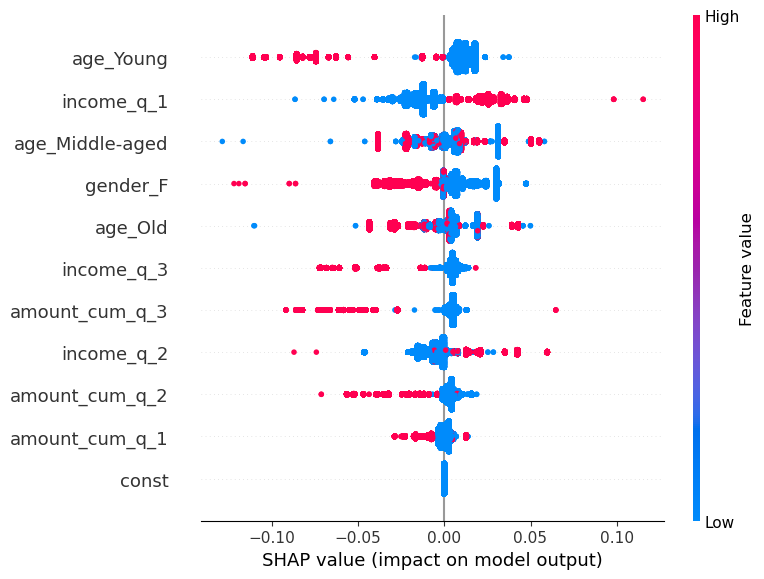

In [193]:
# Plot SHAP summary plot to understand overall feature importance
shap.summary_plot(shap_values[:, :, 1], X, show=False)  # [1] indicates SHAP values for class '1' 

The SHAP values also show that being in the second and third income quartiles increases the probability of viewing an offer. Other variables, such as being young, decrease the probability of viewing an offer.

## Offer Completed: Logit Regression

In [194]:
explanatory_variables = [
    'amount_cum_q_1', 'amount_cum_q_2', 'amount_cum_q_3',
    'difficulty_standardized', 'reward_standardized', 
    'age_Young', 'age_Middle-aged', 'age_Old', 
    'gender_F', 'income_q_1', 'income_q_2', 'income_q_3',
    'income_q_1_diff_interaction', 'income_q_2_diff_interaction', 'income_q_3_diff_interaction',
    'income_q_1_reward_interaction', 'income_q_2_reward_interaction', 'income_q_3_reward_interaction',
    'offer_type_discount', 'reward_discount_interaction',
    'offer_viewed']

As a first step to understand the important variables affecting the probability of completing an offer, a logit model is estimated. The dependent variable is a dummy indicating whether an offer is completed. Independent variables include categorical age group, gender, income group, and accumulated transaction amount for each person, whether an offer is viewed, and whether the offer type is Discount—all as dummy variables. Standardized difficulty and reward values of each offer are also included.

Interaction terms between income quartiles and difficulty or reward, as well as between Discount offers and reward levels, are included to capture more nuanced effects.

In [195]:
# Set up the Logit model using 'offer_completed' as the dependent variable
# Explanatory variables include the constant and the previously defined explanatory variables
clf = sm.Logit(df['offer_completed'], df[const + explanatory_variables])

# Fit the model with clustered standard errors based on 'person' to account for within-group correlation
logit_res = clf.fit(cov_type='cluster', cov_kwds={'groups': df['person']})

# Display the summary of the logistic regression results
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.501325
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        offer_completed   No. Observations:                76277
Model:                          Logit   Df Residuals:                    76255
Method:                           MLE   Df Model:                           21
Date:                Mon, 28 Oct 2024   Pseudo R-squ.:                  0.2675
Time:                        15:48:51   Log-Likelihood:                -38240.
converged:                       True   LL-Null:                       -52204.
Covariance Type:              cluster   LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -3.4730      0.048    -72.329      0.000      -3.567      -3.379
amount_cum_q_1                    1.0600      0.027     38.563      0.000       1.006       1.114
amount_cum_q_2                    1.4136      0.031     45.089      0.000       1.352       1.475
amount_cum_q_3                    1.5825      0.036     43.493      0.000       1.511       1.654
difficulty_standardized          -0.7112      0.030    -23.607      0.000      -0.770      -0.652
reward_standardized               1.0251      0.022     45.779      0.000       0.981       1.069
age_Young                         1.1318      0.050     22.621      0.000       1.034       1.230
age_Middle-aged                   1.3251      0.046     28.583      0.000       1.234       1.416
age_Old                           1.3298      0.048     27.780      0.000       1.236       1.424
gender_F                          0.3904      0.024     16.424      0.000       0.344       0.437
income_q_1                        0.2885      0.027     10.869      0.000       0.236       0.340
income_q_2                        0.5954      0.034     17.425      0.000       0.528       0.662
income_q_3                        0.5660      0.043     13.054      0.000       0.481       0.651
income_q_1_diff_interaction       0.1538      0.023      6.716      0.000       0.109       0.199
income_q_2_diff_interaction       0.3772      0.030     12.665      0.000       0.319       0.436
income_q_3_diff_interaction       0.3890      0.040      9.627      0.000       0.310       0.468
income_q_1_reward_interaction     0.2578      0.022     11.749      0.000       0.215       0.301
income_q_2_reward_interaction     0.5362      0.034     15.803      0.000       0.470       0.603
income_q_3_reward_interaction     0.5594      0.049     11.346      0.000       0.463       0.656
offer_type_discount               2.3141      0.060     38.554      0.000       2.196       2.432
reward_discount_interaction      -1.1481      0.053    -21.808      0.000      -1.251      -1.045
offer_viewed                     -0.0417      0.022     -1.933      0.053      -0.084       0.001
=================================================================================================
"""

In [196]:
# Get the odds ratios by exponentiating the coefficients from the logistic regression model
odds_ratios = pd.DataFrame({
    'Variables': df[const + explanatory_variables].columns,  # List of variables
    'Odds Ratios': np.exp(logit_res.params)  # Exponentiated coefficients to get odds ratios
})

# Print the odds ratios, sorted from highest to lowest
print(odds_ratios.sort_values(by=['Odds Ratios'], ascending=False))

                                                   Variables  Odds Ratios
offer_type_discount                      offer_type_discount    10.115523
amount_cum_q_3                                amount_cum_q_3     4.867227
amount_cum_q_2                                amount_cum_q_2     4.110792
age_Old                                              age_Old     3.780446
age_Middle-aged                              age_Middle-aged     3.762436
age_Young                                          age_Young     3.101254
amount_cum_q_1                                amount_cum_q_1     2.886302
reward_standardized                      reward_standardized     2.787404
income_q_2                                        income_q_2     1.813701
income_q_3                                        income_q_3     1.761282
income_q_3_reward_interaction  income_q_3_reward_interaction     1.749661
income_q_2_reward_interaction  income_q_2_reward_interaction     1.709518
gender_F                              

Running the logit regression, nearly all estimated coefficients, except the coefficient of the offer viewed dummy, are statistically significant! Examining the Odds Ratios, discount offers have a higher probability of being completed. Additionally, a higher accumulated transaction amount for each person increases the probability of completing an offer, which may indicate that long-time or frequent customers are more familiar with the offers.

Older individuals, middle-aged, and younger individuals (in that order) have a higher probability of completing an offer compared to individuals with unknown age, though these age groups are correlated with income levels.

A higher reward also increases the likelihood of offer completion, with a stronger effect observed among higher-income individuals. Similarly, higher difficulty decreases the probability of completing an offer due to increased spending requirements; however, this effect is less pronounced among higher-income individuals.

In [197]:
# Extract and print the AIC (Akaike Information Criterion) value from the logit regression model
aic_value = logit_res.aic
print("AIC:", aic_value)

AIC: 76523.18490770065


In [198]:
# Define the matrix of explanatory variables
X = df[const + explanatory_variables]

# Create a DataFrame to store the VIF (Variance Inflation Factor) values
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF values for each feature
print(vif_data)

                          Feature        VIF
0                           const  14.903703
1                  amount_cum_q_1   1.120397
2                  amount_cum_q_2   1.130053
3                  amount_cum_q_3   1.123863
4         difficulty_standardized  12.554637
5             reward_standardized   7.258302
6                       age_Young   2.047326
7                 age_Middle-aged   3.363870
8                         age_Old   3.329006
9                        gender_F   1.167823
10                     income_q_1   1.546339
11                     income_q_2   1.575931
12                     income_q_3   1.336357
13    income_q_1_diff_interaction   2.375774
14    income_q_2_diff_interaction   1.845366
15    income_q_3_diff_interaction   1.524055
16  income_q_1_reward_interaction   2.397196
17  income_q_2_reward_interaction   1.847711
18  income_q_3_reward_interaction   1.530375
19            offer_type_discount  12.382971
20    reward_discount_interaction   3.384303
21        

The VIF analysis above shows that difficulty, reward, and the Discount offer type have high correlations with other variables, possibly with each other.

In [199]:
print(df['difficulty'].corr(df['reward']))
print(df['difficulty_standardized'].corr(df['reward_standardized']))
print(df['difficulty_standardized'].corr(df['offer_type_discount']))

0.46526619205437886
0.46526619205437764
0.5978900608731922


## Offer Completed: Random Forest
Considering completed offers and adding the "offer viewed" dummy as a feature using a Random Forest Classifier.

In [200]:
#explanatory_variables = [
#    'offer_viewed', 'amount_cum_q_1', 'amount_cum_q_2', 'amount_cum_q_3',
#    'difficulty_standardized', 'reward_standardized',
#    'age_Young', 'age_Middle-aged', 'age_Old', 'gender_F', 
#    'income_q_1', 'income_q_2', 'income_q_3',
#    'income_q_1_diff_interaction', 'income_q_2_diff_interaction', 'income_q_3_diff_interaction',
#    'income_q_1_reward_interaction', 'income_q_2_reward_interaction', 'income_q_3_reward_interaction',
#    'offer_type_discount', 'reward_discount_interaction']

In [201]:
explanatory_variables = [
    'offer_viewed', 'amount_cum_q_1', 'amount_cum_q_2', 'amount_cum_q_3',
    'difficulty_standardized', 'reward_standardized', 
    'age_Young', 'age_Middle-aged', 'age_Old', 
    'gender_F', 'income_q_1', 'income_q_2', 'income_q_3',
    'offer_type_discount']

In [202]:
# X is the dataframe containing all the features, and y is the target ('offer_completed')
X = df[const + explanatory_variables]
y = df['offer_completed']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Feature importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
completed = feature_importance_df
print(feature_importance_df)

Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81     12881
           1       0.74      0.82      0.78     10003

    accuracy                           0.80     22884
   macro avg       0.80      0.80      0.80     22884
weighted avg       0.80      0.80      0.80     22884

Accuracy: 0.7978937248732739
                    Feature  Importance
6       reward_standardized    0.242558
5   difficulty_standardized    0.240059
3            amount_cum_q_2    0.082803
4            amount_cum_q_3    0.066610
10                 gender_F    0.062812
2            amount_cum_q_1    0.062207
12               income_q_2    0.047600
14      offer_type_discount    0.042627
8           age_Middle-aged    0.030960
1              offer_viewed    0.030041
9                   age_Old    0.025484
13               income_q_3    0.025129
11               income_q_1    0.024941
7                 age_Young    0.016168
0         

In [203]:
# Initialize the SHAP explainer using the trained model
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X)

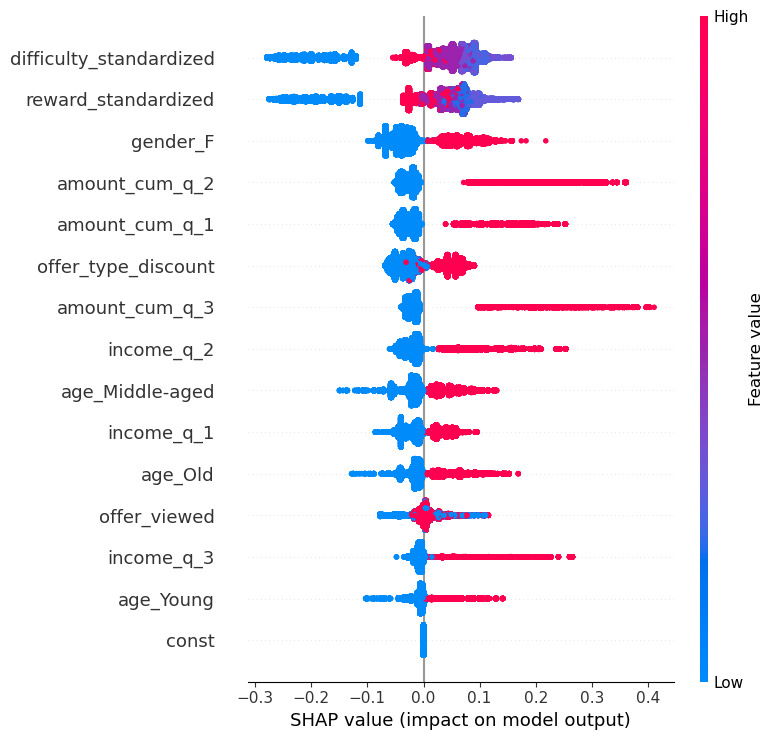

In [204]:
# Plot SHAP summary plot to understand overall feature importance
shap.summary_plot(shap_values[:, :, 1], X, show=False) 

# Save the plot as a PNG file
plt.savefig('shap_summary_plot.png', format='png', dpi=300, bbox_inches='tight')

As can be seen from the above graph, all variables, except difficulty, and reward, contribute to a higher probability of completing an offer when their value is 1.
  
Next, I will perform the same analysis using a Random Forest Classifier for Discount and Bogo offers separately. This is because their difficulty and reward schemes differ, and I aim to see whether other factors, such as income or spending history, affect customer behavior.

## Offer Viewed and Completed
The dummy variable that indicates whether an offer is both viewed and completed is considered as the dependent variable. A Random Forest Classifier is used for this analysis.

In [205]:
# Define the explanatory variables and the target ('offer_viewed_completed')
explanatory_variables = [
    'amount_cum_q_1', 'amount_cum_q_2', 'amount_cum_q_3',
    'difficulty_standardized', 'reward_standardized',
    'age_Young', 'age_Middle-aged', 'age_Old', 
    'gender_F', 'income_q_1', 'income_q_2', 'income_q_3',
    'offer_type_discount'
]

# Define the matrix of features (X) and the target (y)
X = df[const + explanatory_variables]
y = df['offer_viewed_completed']

# Train-test split (70% training data, 30% test data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate model performance using classification metrics and accuracy
print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Store classification report for later use
viewed_completed = classification_report(y_test, y_pred)

# Calculate feature importance and display it
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82     15840
           1       0.60      0.47      0.53      7044

    accuracy                           0.74     22884
   macro avg       0.70      0.67      0.68     22884
weighted avg       0.73      0.74      0.73     22884

Accuracy: 0.7427023247683971
                    Feature  Importance
5       reward_standardized    0.294379
4   difficulty_standardized    0.271604
2            amount_cum_q_2    0.066202
11               income_q_2    0.052876
9                  gender_F    0.051568
13      offer_type_discount    0.048749
1            amount_cum_q_1    0.047665
3            amount_cum_q_3    0.039908
10               income_q_1    0.033271
7           age_Middle-aged    0.027856
8                   age_Old    0.025738
12               income_q_3    0.023948
6                 age_Young    0.016234
0                     const    0.000000


In [206]:
print(completed)

                    Feature  Importance
6       reward_standardized    0.242558
5   difficulty_standardized    0.240059
3            amount_cum_q_2    0.082803
4            amount_cum_q_3    0.066610
10                 gender_F    0.062812
2            amount_cum_q_1    0.062207
12               income_q_2    0.047600
14      offer_type_discount    0.042627
8           age_Middle-aged    0.030960
1              offer_viewed    0.030041
9                   age_Old    0.025484
13               income_q_3    0.025129
11               income_q_1    0.024941
7                 age_Young    0.016168
0                     const    0.000000


Using "offer_completed" or "offer_viewed_completed" as the dependent variable does not show significant differences in the key influencing variables. Additionally, accuracy and recall are higher when "offer_completed" is used. Therefore, I will focus on offers that are completed.

## Only Discount Offers

In [207]:
# Define the explanatory variables for the Discount offers
explanatory_variables = [
    'amount_cum_q_1', 'amount_cum_q_2', 'amount_cum_q_3',
    'difficulty_standardized', 'reward_standardized', 
    'age_Young', 'age_Middle-aged', 'age_Old', 'gender_F',
    'income_q_1', 'income_q_2', 'income_q_3'
]

# Filter the dataset for only Discount offers
df_discount = df[df.offer_type_discount == 1].copy()

# Standardize the 'difficulty' and 'reward' columns
difficulty_scaler = StandardScaler()
reward_scaler = StandardScaler()
df_discount['difficulty_standardized'] = difficulty_scaler.fit_transform(df_discount[['difficulty']])
df_discount['reward_standardized'] = reward_scaler.fit_transform(df_discount[['reward']])

# Define the matrix of features (X) and the target (y)
X = df_discount[const + explanatory_variables]
y = df_discount['offer_completed']

# Train-test split (70% training data, 30% test data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate model performance using classification metrics and accuracy
print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Calculate feature importance and display it
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       0.70      0.60      0.65      3955
           1       0.73      0.80      0.76      5208

    accuracy                           0.72      9163
   macro avg       0.71      0.70      0.70      9163
weighted avg       0.71      0.72      0.71      9163

Accuracy: 0.7159227327294554
                    Feature  Importance
2            amount_cum_q_2    0.147116
1            amount_cum_q_1    0.144937
3            amount_cum_q_3    0.125372
9                  gender_F    0.124704
11               income_q_2    0.092678
5       reward_standardized    0.064410
4   difficulty_standardized    0.061094
7           age_Middle-aged    0.059640
10               income_q_1    0.050137
12               income_q_3    0.049402
8                   age_Old    0.046773
6                 age_Young    0.033737
0                     const    0.000000


              precision    recall  f1-score   support

           0       0.70      0.60      0.65      3955
           1       0.73      0.80      0.76      5208

    accuracy                           0.72      9163
   macro avg       0.71      0.70      0.70      9163
weighted avg       0.71      0.72      0.71      9163



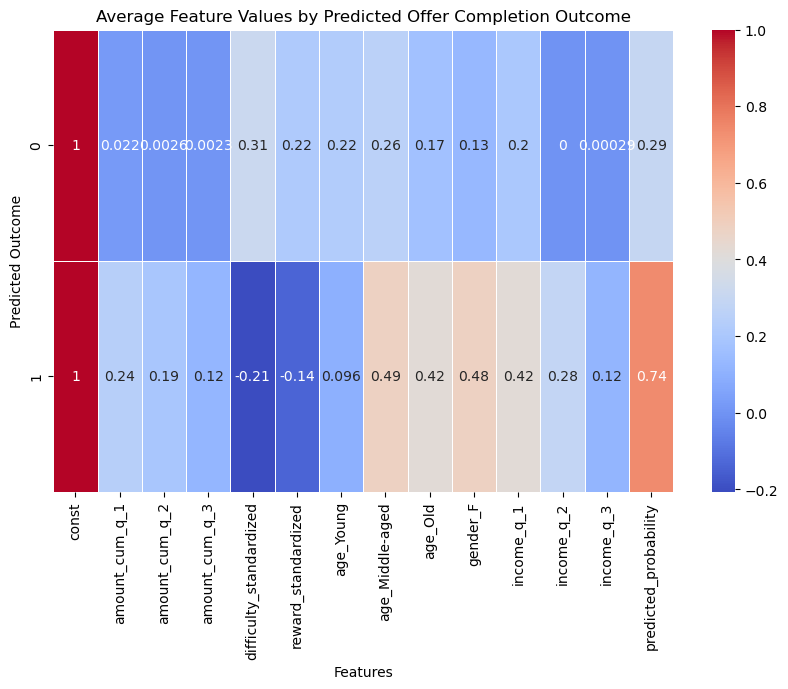

In [208]:
# Use the trained Random Forest model to predict probabilities for X_test
y_pred_proba = rf_model.predict_proba(X_test)

# Extract the probabilities for class 1 (i.e., offer viewed and completed)
probabilities_class_1 = y_pred_proba[:, 1]

# Classify observations based on a probability threshold (default is 0.5)
threshold = 0.5
y_pred_high_prob = (probabilities_class_1 >= threshold).astype(int)

# Evaluate the model's performance using the classification report
print(classification_report(y_test, y_pred_high_prob))

# Add the predicted probabilities and assigned outcomes to the test DataFrame for further analysis
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)  # Ensure column consistency between train and test sets
X_test_df['predicted_probability'] = probabilities_class_1
X_test_df['assigned_offer_outcome'] = y_pred_high_prob

# Calculate average feature values grouped by assigned offer outcome (0 or 1)
group_means = X_test_df.groupby('assigned_offer_outcome').mean()

# Visualize the average feature values by predicted offer completion outcome using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(group_means, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Average Feature Values by Predicted Offer Completion Outcome')
plt.xlabel('Features')
plt.ylabel('Predicted Outcome')

# Save the plot
plt.savefig('discount_offers.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

For Discount offers, the graph comparing individuals who are predicted to complete an offer versus those who are not shows that people prefer lower difficulty levels for nearly the same reward levels. Additionally, a higher fraction of young individuals do not complete offers compared to those who do. Conversely, a greater proportion of middle-aged and older individuals complete offers compared to individuals in the same age groups who are predicted not to.

Individuals in the third and fourth income quartiles are the most likely to complete an offer, and those with higher spending histories are also more inclined to complete an offer.

In [209]:
# Define the standardized values for difficulty and reward
average_values = [[0.31, 0.22], [-0.21, -0.14]]

# Loop over each set of standardized values (for difficulty and reward)
for i in range(0, 2):
    standardized_value_difficulty = average_values[i][0]
    standardized_value_reward = average_values[i][1]
    
    # Inverse transform the standardized value of 'difficulty' back to its original scale
    original_value_difficulty = difficulty_scaler.inverse_transform([[standardized_value_difficulty]])[0][0]
    print(f"The original value corresponding to the standardized value {standardized_value_difficulty} for 'difficulty' is: {original_value_difficulty}")
    
    # Inverse transform the standardized value of 'reward' back to its original scale
    original_value_reward = reward_scaler.inverse_transform([[standardized_value_reward]])[0][0]
    print(f"The original value corresponding to the standardized value {standardized_value_reward} for 'reward' is: {original_value_reward}")

The original value corresponding to the standardized value 0.31 for 'difficulty' is: 13.286521154372783
The original value corresponding to the standardized value 0.22 for 'reward' is: 3.273200269773285
The original value corresponding to the standardized value -0.21 for 'difficulty' is: 10.725153719844823
The original value corresponding to the standardized value -0.14 for 'reward' is: 2.831877886384328


In [210]:
df_discount[['reward_standardized', 'difficulty_standardized']].describe()

,reward_standardized,difficulty_standardized
count,3.054300e+04,3.054300e+04
mean,-3.596566e-16,1.203205e-16
std,1.000016e+00,1.000016e+00
min,-8.185879e-01,-9.662679e-01
25%,-8.185879e-01,-9.662679e-01
50%,-2.857713e-03,-3.572182e-01
75%,1.628603e+00,1.672947e+00
max,1.628603e+00,1.672947e+00


## Only Bogo Offers

In [211]:
# Define explanatory variables for Bogo offers
explanatory_variables = [
    'amount_cum_q_1', 'amount_cum_q_2', 'amount_cum_q_3', 
    'difficulty', 'age_Young', 'age_Middle-aged', 'age_Old', 
    'gender_F', 'income_q_1', 'income_q_2', 'income_q_3'
]

# Filter the dataset for Bogo offers only
df_bogo = df[df.offer_type_bogo == 1].copy()

# Standardize the 'difficulty' and 'reward' columns
difficulty_scaler = StandardScaler()
reward_scaler = StandardScaler()
df_bogo['difficulty_standardized'] = difficulty_scaler.fit_transform(df_bogo[['difficulty']])
df_bogo['reward_standardized'] = reward_scaler.fit_transform(df_bogo[['reward']])

# Define the matrix of features (X) and the target (y)
X = df_bogo[const + explanatory_variables]
y = df_bogo['offer_completed']

# Train-test split (70% training data, 30% test data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance using classification metrics and accuracy
print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Calculate feature importance and display it
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      4469
           1       0.74      0.76      0.75      4681

    accuracy                           0.74      9150
   macro avg       0.74      0.74      0.74      9150
weighted avg       0.74      0.74      0.74      9150

Accuracy: 0.7374863387978142
            Feature  Importance
2    amount_cum_q_2    0.194489
3    amount_cum_q_3    0.156343
8          gender_F    0.155575
1    amount_cum_q_1    0.126240
10       income_q_2    0.101486
4        difficulty    0.059595
11       income_q_3    0.050847
6   age_Middle-aged    0.047076
9        income_q_1    0.047065
7           age_Old    0.039919
5         age_Young    0.021365
0             const    0.000000


              precision    recall  f1-score   support

           0       0.74      0.72      0.73      4469
           1       0.74      0.76      0.75      4681

    accuracy                           0.74      9150
   macro avg       0.74      0.74      0.74      9150
weighted avg       0.74      0.74      0.74      9150



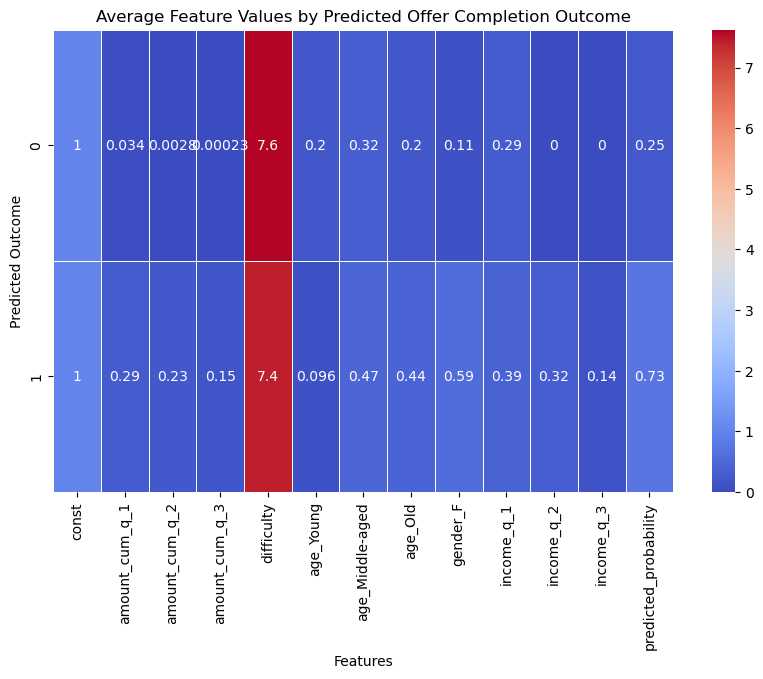

In [212]:
# Use the trained Random Forest model to predict probabilities for X_test
y_pred_proba = rf_model.predict_proba(X_test)

# Extract the probabilities for class 1 (i.e., offer completed)
probabilities_class_1 = y_pred_proba[:, 1]

# Classify observations based on a probability threshold (default is 0.5)
threshold = 0.5
y_pred_high_prob = (probabilities_class_1 >= threshold).astype(int)

# Evaluate the model's performance using the classification report
print(classification_report(y_test, y_pred_high_prob))

# Add the predicted probabilities and assigned outcomes to the test DataFrame for further analysis
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)
X_test_df['predicted_probability'] = probabilities_class_1
X_test_df['assigned_offer_outcome'] = y_pred_high_prob

# Calculate average feature values grouped by assigned offer outcome (0 or 1)
group_means = X_test_df.groupby('assigned_offer_outcome').mean()

# Visualize the average feature values by predicted offer completion outcome using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(group_means, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Average Feature Values by Predicted Offer Completion Outcome')
plt.xlabel('Features')
plt.ylabel('Predicted Outcome')

# Save the plot
plt.savefig('bogo_offers.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

For Bogo offers, we observe that a low fraction of young individuals complete an offer. Additionally, a higher fraction of people with a spending history and individuals with higher income levels complete a Bogo offer. The difficulty and reward values are either 5 or 10, and the graph shows that the average values in both groups are close to each other. This suggests that the difficulty level does not play a significant role in determining who will complete an offer.

One reason is that BOGO offers are more probable to be completed when more than one person are having coffee, then average difficlty, for two persons, is low for either offer. 

## Different Offers: Multi-level Classification

              precision    recall  f1-score   support

           0       0.72      0.65      0.68      8258
           1       0.71      0.71      0.71      1011
           2       0.75      0.92      0.82      1566
           3       0.74      0.81      0.77      2779
           4       0.73      0.77      0.75      2065
           5       0.74      0.73      0.74      2634

    accuracy                           0.73     18313
   macro avg       0.73      0.77      0.75     18313
weighted avg       0.73      0.73      0.73     18313



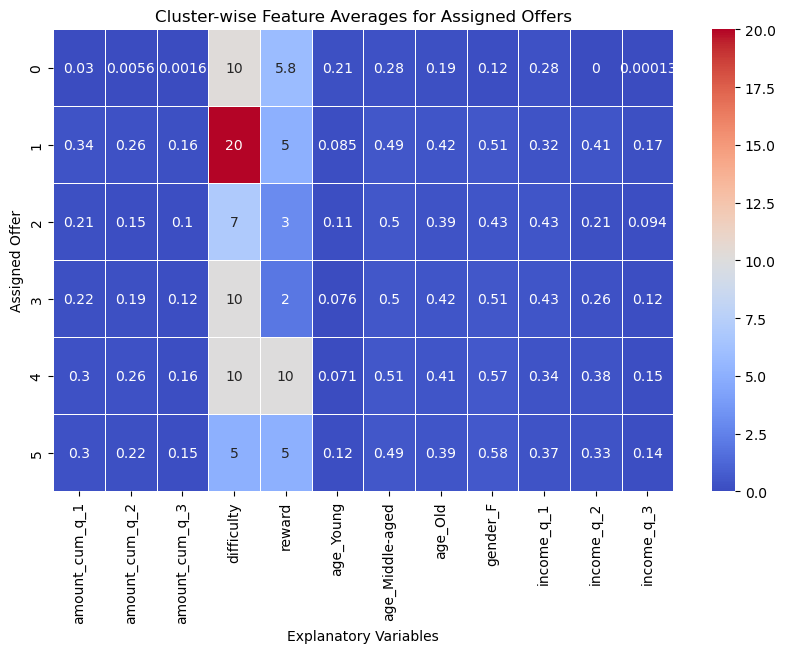

In [213]:
df_modified = df[df['offer_type'] != 'informational']
df_modified = df_modified.copy()

label_encoder = LabelEncoder()
label_encoder.fit(df_modified['id'])
df_modified['offer_id'] = label_encoder.transform(df_modified['id']) + 1  # Ensure encoded values start from 1

# Ensure consistency for offer IDs by reassigning specific values
df_modified.loc[df_modified['offer_id'] == 8, 'offer_id'] = 3
df_modified.loc[df_modified['offer_id'] == 6, 'offer_id'] = 4
df_modified.loc[df_modified['offer_id'] == 7, 'offer_id'] = 5

# Create a new target variable 'offer_id_completed' as the product of offer completion and offer ID
df_modified['offer_id_completed'] = df_modified['offer_completed'] * df_modified['offer_id']

# Define explanatory variables
explanatory_variables = [
    'amount_cum_q_1', 'amount_cum_q_2', 'amount_cum_q_3',
    'difficulty', 'reward', 
    'age_Young', 'age_Middle-aged', 'age_Old', 'gender_F', 
    'income_q_1', 'income_q_2', 'income_q_3'
]

# Define the matrix of features (X) and the target (y)
X = df_modified[const + explanatory_variables]
y = df_modified['offer_id_completed']

# Train-test split (70% training data, 30% test data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate and train the Random Forest Classifier for multi-class classification
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model's performance using classification metrics
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Assign predicted offers to the test data
X_test['assigned_offer'] = rf_model.predict(X_test)

# Calculate average feature values grouped by the assigned offer
group_means = X_test.groupby('assigned_offer')[explanatory_variables].mean()

# Visualize the average feature values by assigned offer using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(group_means, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Cluster-wise Feature Averages for Assigned Offers')
plt.xlabel('Explanatory Variables')
plt.ylabel('Assigned Offer')

# Save the plot
plt.savefig('multi_level.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

In the multi-level classification, the model does not reclassify individuals who completed the offers initially sent to them. The model predicts that more young people with low spending histories are unlikely to complete any offer. A very low fraction of young individuals complete offers with difficulties of 10 or 20. Conversely, individuals with income levels in the 3rd or 4th quartile are less likely not to complete an offer.

Overall, the results suggest that if the goal of the offers is to attract new customers, higher income levels should be targeted, as they are less likely not to complete an offer. If the goal is to encourage current customers to consume more, offers with low difficulty should be targeted toward young people. Higher-income individuals are more likely to complete offers; however, whether they should be targeted requires further analysis to determine the impact of offers on the spending behavior of mobile app members.